# README

This takes the data generated from gen_2DWindow_data.py and converts it into graphs. This experiment is taking 12 curves where there are windows around the null points. These windows around the null points are varied to show how close we need to be to the null point to have improved MSE beyond the conventional method. This code is changed from the npWindow experiment in that both windows vary in the central location. We also allow the SNR to vary.

# Libraries

In [1]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as scipy
# import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
import pickle
import functools
import os
from matplotlib.ticker import MultipleLocator

# Initialization

### Window Analysis

In [2]:
# SNR_index_oi = 2

cwd_temp = os.getcwd()
base_file = 'Stabilization'
cwd_full = cwd_temp.split(base_file, 1)[0]
print(cwd_full)

exp_file = 'Reassign_T2rat_DATA'
exp_date = '23Feb24'

add_tag = "standard"
method = "AIC"

param_oi = 2

assert(param_oi >= 0 and param_oi < 6)

ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']

/home/hamptong2/


In [3]:
with open(f'{cwd_full}{base_file}/Reassign_Experiment/{exp_file}/hprParameter_{method}_{add_tag}_T2rat_SNRsuite_{exp_date}.pkl', 'rb') as handle:
    
    dict = pickle.load(handle)
    np1_array = dict['np1_array']
    np2_array = dict['np2_array']
    T2rat_array = dict['T2_ratio']
    SNR_array = dict["SNR_array"]
    true_params = dict["true_params"]
    nTE = dict["nTE"]
    dTE = dict["dTE"]
    var_reps = dict["var_reps"]
    multi_start = dict['multi_start']
    handle.close()

T11, T12, c1, c2, T21 = true_params

#Uncalculable with the variable T22 value
# R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
# R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)

TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

# print(f"SNR of interest = {SNR_array[SNR_index_oi]:0.2f}")

### Standard Analysis

In [4]:
SR_folder = 'Comparison_DATA'
SR_date = '26Feb24'
SR_run = 'SNRsuite_T2rat'

In [5]:
with open(f'{cwd_full}{base_file}/Standard_Comparisons/{SR_folder}/hprParameter_AIC_{SR_run}_{SR_date}.pkl', 'rb') as handle:
    
    dict = pickle.load(handle)
    SR_SNR_values = dict["SNR_array"]
    SR_T2rat_array = dict["T2_ratio"]
    SR_true_params = dict["true_params"]
    SR_TI_STANDARD = dict["TI_DATA"]
    SR_nTE = dict["nTE"]
    SR_dTE = dict["dTE"]
    SR_var_reps = dict["var_reps"]
    SR_multi_start = dict['multi_start']
    handle.close()

for iter in range(len(true_params)):
    assert(SR_true_params[iter] == true_params[iter])

for iter in range(len(T2rat_array)):
    assert(np.any(SR_T2rat_array, where = T2rat_array[iter]))

for iter in range(len(SNR_array)):
    assert(np.any(SR_SNR_values, where=SNR_array[iter]))

# Functions

In [6]:
def to_readable_2DWindow(file):
    df = pd.read_pickle(file)
    ALL_CENTER1 = np.stack(df["NP1"].values) #shape: 
    ALL_CENTER2 = np.stack(df["NP2"].values) #shape: 
    ALL_T2RAT = np.stack(df["T2_rat"].values) #shape: 
    ALL_SNR = np.stack(df["SNR"].values) #shape: 
    ALL_TI = np.stack(df["TI_DATA"].values) #shape:  #shape: 
    ALL_SNR_eTime = np.stack(df["SNR_eTime"].values) #shape:  
    ALL_MSE = np.stack(df["MSE"].values) #shape: 
    ALL_VAR = np.stack(df["var"].values) #shape: 

    ALL_BIAS = np.stack(df["bias"].values) #shape: 

    ALL_pEst_AIC = np.stack(df["pEst_AIC"].values) #shape: 
    ALL_pEst_cf = np.stack(df["pEst_cf"].values) #shape: 
    
    return ALL_CENTER1, ALL_CENTER2, ALL_T2RAT, ALL_SNR, ALL_TI, ALL_SNR_eTime, ALL_MSE, ALL_VAR, ALL_BIAS, ALL_pEst_AIC, ALL_pEst_cf

def to_readable_SR(file):
    df = pd.read_pickle(file)
    ALL_SNR = np.stack(df["SNR"].values) #shape: 
    ALL_T2RAT = np.stack(df["T2_rat"].values) #shape: 
    ALL_MSE = np.stack(df["MSE"].values) #shape: 
    ALL_VAR = np.stack(df["var"].values) #shape: 

    ALL_BIAS = np.stack(df["bias"].values) #shape: 

    ALL_pEst_AIC = np.stack(df["pEst_AIC"].values) #shape: 
    ALL_pEst_cf = np.stack(df["pEst_cf"].values) #shape: 
    
    return ALL_SNR, ALL_T2RAT, ALL_MSE, ALL_VAR, ALL_BIAS, ALL_pEst_AIC, ALL_pEst_cf


def int_lengh_AIC(R0, diff_TE, SNR):
    return (2*diff_TE/(R0*SNR**2))**(1/2)

def calc_MSE(paramStore, true_params, clipped = False):
    varMat = np.var(paramStore, axis=0)
    biMat = np.mean(paramStore, axis = 0) - true_params  #E[p_hat] - p_true
    MSEMat = varMat + biMat**2
    if clipped:
        return MSEMat[-4:], biMat[-4:], varMat[-4:]
    return MSEMat, varMat, biMat

def _get_colors(num_colors):
    colors = []
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() *10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

In [7]:
def trapz_3d(x, y, z):
    area = 0
    for iY in range(z.shape[0]-1):
        for iX in range(z.shape[1]-1):
            four_corners = [z[iY,iX], z[iY+1,iX], z[iY,iX+1], z[iY+1,iX+1]]
            corner_sig = np.mean(four_corners)
            rect_base = (x[iX+1]-x[iX])*(y[iY+1]-y[iY])
            area = area + corner_sig*rect_base
    return area


In [8]:
def prepare_data(p_oi):
    # ordering = ["ESPRESSO", "Conventional", "Curve Fit"]
    MSE_ordered = np.zeros((len(np1_array), len(np2_array), len(T2rat_array), len(SNR_array),3))
    var_ordered = np.zeros((len(np1_array), len(np2_array), len(T2rat_array), len(SNR_array),3))
    bias_ordered = np.zeros((len(np1_array), len(np2_array), len(T2rat_array), len(SNR_array),3))

    eqSNR_ordered = np.zeros((len(np1_array), len(np2_array), len(T2rat_array), len(SNR_array)))
    TI_ordered = np.zeros((len(np1_array), len(np2_array), len(T2rat_array), len(SNR_array), 12))

    pEst_AIC_ordered = np.zeros((len(np1_array), len(np2_array), len(T2rat_array), len(SNR_array), var_reps, len(ParamTitle_6p)))
    pEst_cf_ordered = np.zeros((len(np1_array), len(np2_array), len(T2rat_array), len(SNR_array), var_reps, len(ParamTitle_6p)))

    data_name = f"{cwd_full}{base_file}/Reassign_Experiment/{exp_file}/reassignExp_{method}_{add_tag}_T2rat_SNRsuite_{exp_date}.pkl"

    print("Retrieving data for " + data_name)
    NP1, NP2, T2RAT, var_SNR, TI_DATA, eqSNR, MSE, VAR, BIAS, pEst_AIC, pEst_cf = to_readable_2DWindow(data_name)

    for index in range(len(MSE)):

        temp_np1 = NP1[index]
        temp_np2 = NP2[index]
        temp_T2rat = T2RAT[index]
        temp_SNR = var_SNR[index]


        np1_index = np.where(temp_np1==np1_array)[0][0]
        np2_index = np.where(temp_np2==np2_array)[0][0]
        T2rat_index = np.where(temp_T2rat==T2rat_array)[0][0]
        SNR_index = np.where(temp_SNR==SNR_array)[0][0]

        MSE_ordered[np1_index, np2_index, T2rat_index, SNR_index, :] = MSE[index,:,p_oi]
        var_ordered[np1_index, np2_index, T2rat_index, SNR_index, :] = VAR[index,:,p_oi]
        bias_ordered[np1_index, np2_index, T2rat_index, SNR_index, :] = BIAS[index,:,p_oi]
        eqSNR_ordered[np1_index, np2_index, T2rat_index, SNR_index] = eqSNR[index]
        TI_ordered[np1_index, np2_index, T2rat_index, SNR_index, :] = TI_DATA[index,:]
        pEst_AIC_ordered[np1_index, np2_index, T2rat_index, SNR_index, :, :] = pEst_AIC[index,:,:]
        pEst_cf_ordered[np1_index, np2_index, T2rat_index, SNR_index, :, :] = pEst_cf[index,:,:]

    return MSE_ordered, var_ordered, bias_ordered, eqSNR_ordered, TI_ordered, pEst_AIC_ordered, pEst_cf_ordered

# Data Organization

In [9]:
MSE, var, bias, SNRs, TI_DATAs, pEst_AIC, pEst_cf = prepare_data(param_oi)

SR_name = f"{cwd_full}{base_file}/Standard_Comparisons/{SR_folder}/{SR_run}_{SR_date}.pkl"
SR_SNR, SR_T2Rat, SR_MSE, SR_VAR, SR_BIAS, SR_pEst_AIC, SR_pEst_cf = to_readable_SR(SR_name)


Retrieving data for /home/hamptong2/Stabilization/Reassign_Experiment/Reassign_T2rat_DATA/reassignExp_AIC_standard_T2rat_SNRsuite_23Feb24.pkl


# Figure Functions

In [10]:
sp_map = plt.get_cmap('seismic_r')
sp_map.set_extremes(under = 'orange')
extend_opt = "neither"      #max or neither

def gen_patchwork_panel(fig, ax, T2_rat, imp_mat, ex_title='', cb_range = 0):
    ######## bottom left

    if cb_range == 0:
        pos_max = np.max(imp_mat)
    else:
        pos_max = cb_range
    T22 = T2_rat*T21

    plt.rc('font', size = 12)
    ax.set_title(f"{ex_title}[{T11:.0f},{T12:.0f},{c1:.2f},{c2:.2f},{T21:.0f},{T22:.0f}]")
    imc1 = ax.imshow(imp_mat[:,:], cmap = sp_map, vmin = -1*pos_max, vmax = pos_max)

    # ax.set_title('Improvement in ' + param_name_list[POI] + ' MSE')
    ax.set_xticks(np.arange(len(np2_array)))
    ax.set_yticks(np.arange(len(np1_array)))

    temp_x_labels = ["" for a in np2_array]
    x_array = [0,len(np2_array)//4,len(np2_array)//2, 3*len(np2_array)//4, -1]
    for elem in x_array:
        temp_x_labels[elem] = f"{np2_array[elem]:0.1f}"
    ax.set_xticklabels(temp_x_labels)

    temp_y_labels = ["" for a in np1_array]
    y_array = [0,len(np1_array)//4,len(np1_array)//2, 3*len(np1_array)//4, -1]
    for elem in y_array:
        temp_y_labels[elem] = f"{np1_array[elem]:0.1f}"
    ax.set_yticklabels(temp_y_labels)

    ax.set_ylabel(r'TI$_1^*$ Guess Offset')
    ax.set_xlabel(r'TI$_2^*$ Guess Offset')
    plt.rc('font', size = 12)
    cbar = fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.2, location = 'bottom', extend = extend_opt)#, format = '%.2e')
    cbar.formatter.set_powerlimits((0,0))

    return

# Heat Maps

2.0000000000000004
0.003640937730821712
(13, 13, 11, 8, 3)
2
10
Area in the 10% region =  171.1056


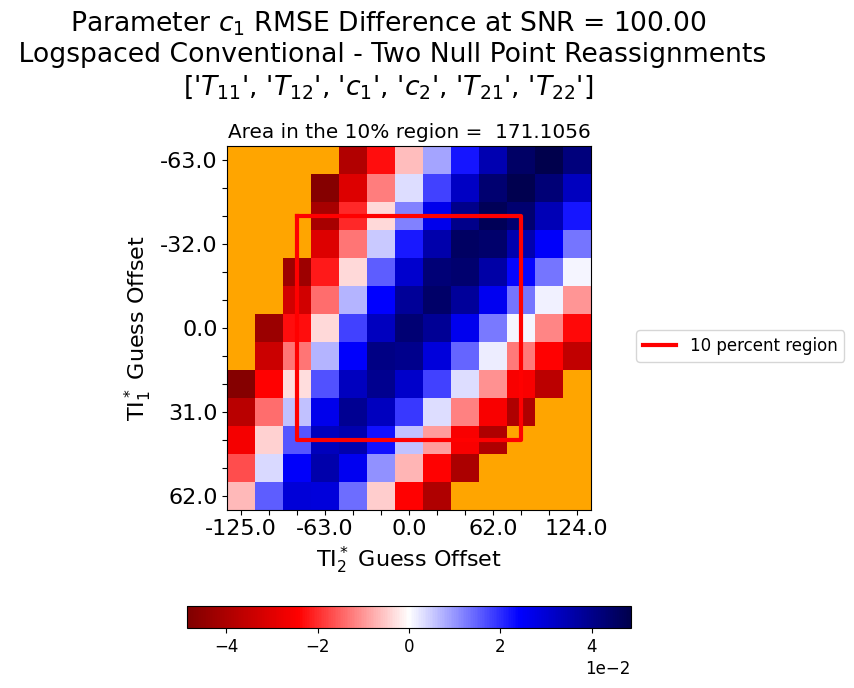

In [11]:
SNR_index_oi = -4
T2rat_index_oi = 5

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize = (6, 7), tight_layout=True)
fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} RMSE Difference at SNR = {SNR_array[SNR_index_oi] :0.2f}\n Logspaced Conventional - Two Null Point Reassignments\n{ParamTitle_6p}")

mat1 = np.where(SNR_array[SNR_index_oi] == SR_SNR)[0]
mat2 = np.where(T2rat_array[T2rat_index_oi] == SR_T2Rat)[0]
SR_index_match = np.intersect1d(mat1,mat2)[0]

temp_SR_MSE = SR_MSE[SR_index_match,param_oi]

print(T2rat_array[T2rat_index_oi])
print(temp_SR_MSE)
print(MSE.shape)

temp_MSE_imp = temp_SR_MSE**(1/2)-MSE[:, : , T2rat_index_oi, SNR_index_oi, 0]**(1/2)

gen_patchwork_panel(fig, ax, T2rat_array[T2rat_index_oi], temp_MSE_imp)
tenD = np.where(np.abs(np1_array/TI1star - -0.1) < 0.003)[0][0]
tenU = np.where(np.abs(np1_array/TI1star - 0.1) < 0.003)[0][0]
print(tenD)
print(tenU)
ax.plot([tenD, tenD, tenU, tenU, tenD],[tenD, tenU, tenU, tenD, tenD], ls = '-', color = 'r', lw = 3, label = '10 percent region')
# ax.legend()
# ax_MSE[1,2].remove()

ex_area = trapz_3d(np1_array[tenD:tenU], np2_array[tenD:tenU], temp_MSE_imp[tenD:tenU, tenD:tenU])
print(f'Area in the 10% region = {ex_area: .4f}')
ax.set_title(f'Area in the 10% region = {ex_area: .4f}')
fig.legend(loc = 'center left', bbox_to_anchor = (0.9,0.5))

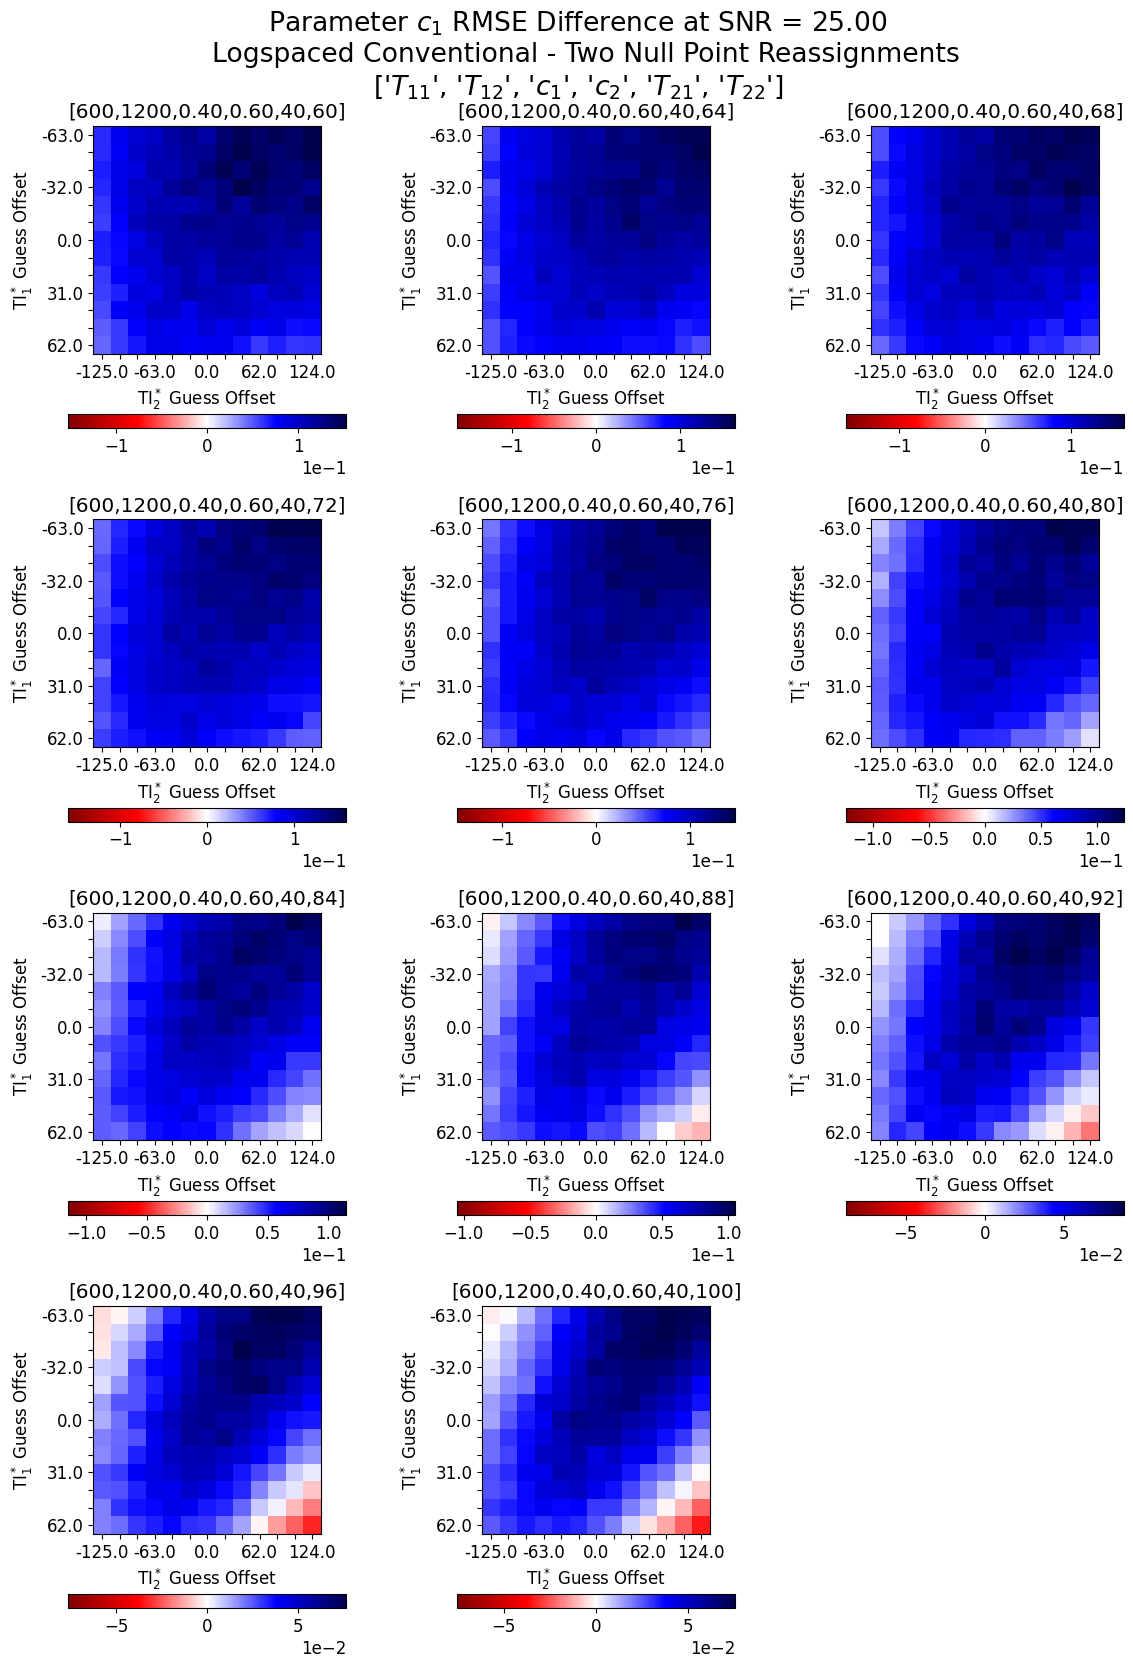

In [12]:
SNR_index_oi = 0

fig, ax = plt.subplots(4,3, figsize = (12, 17), tight_layout=True)
plt.rc('font', size = 16)
fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} RMSE Difference at SNR = {SNR_array[SNR_index_oi] :0.2f}\n  Logspaced Conventional - Two Null Point Reassignments\n{ParamTitle_6p}")
plt.rc('font', size = 12)

for iT2 in range(len(T2rat_array)):

    mat1 = np.where(SNR_array[SNR_index_oi] == SR_SNR)[0]
    mat2 = np.where(T2rat_array[iT2] == SR_T2Rat)[0]
    SR_index_match = np.intersect1d(mat1,mat2)[0]

    temp_SR_MSE = SR_MSE[SR_index_match,param_oi]

    temp_MSE_imp = temp_SR_MSE**(1/2)-MSE[:, : , iT2, SNR_index_oi, 0]**(1/2)

    gen_patchwork_panel(fig, ax[iT2//3, iT2%3], T2rat_array[iT2], temp_MSE_imp)

ax[3,2].remove()

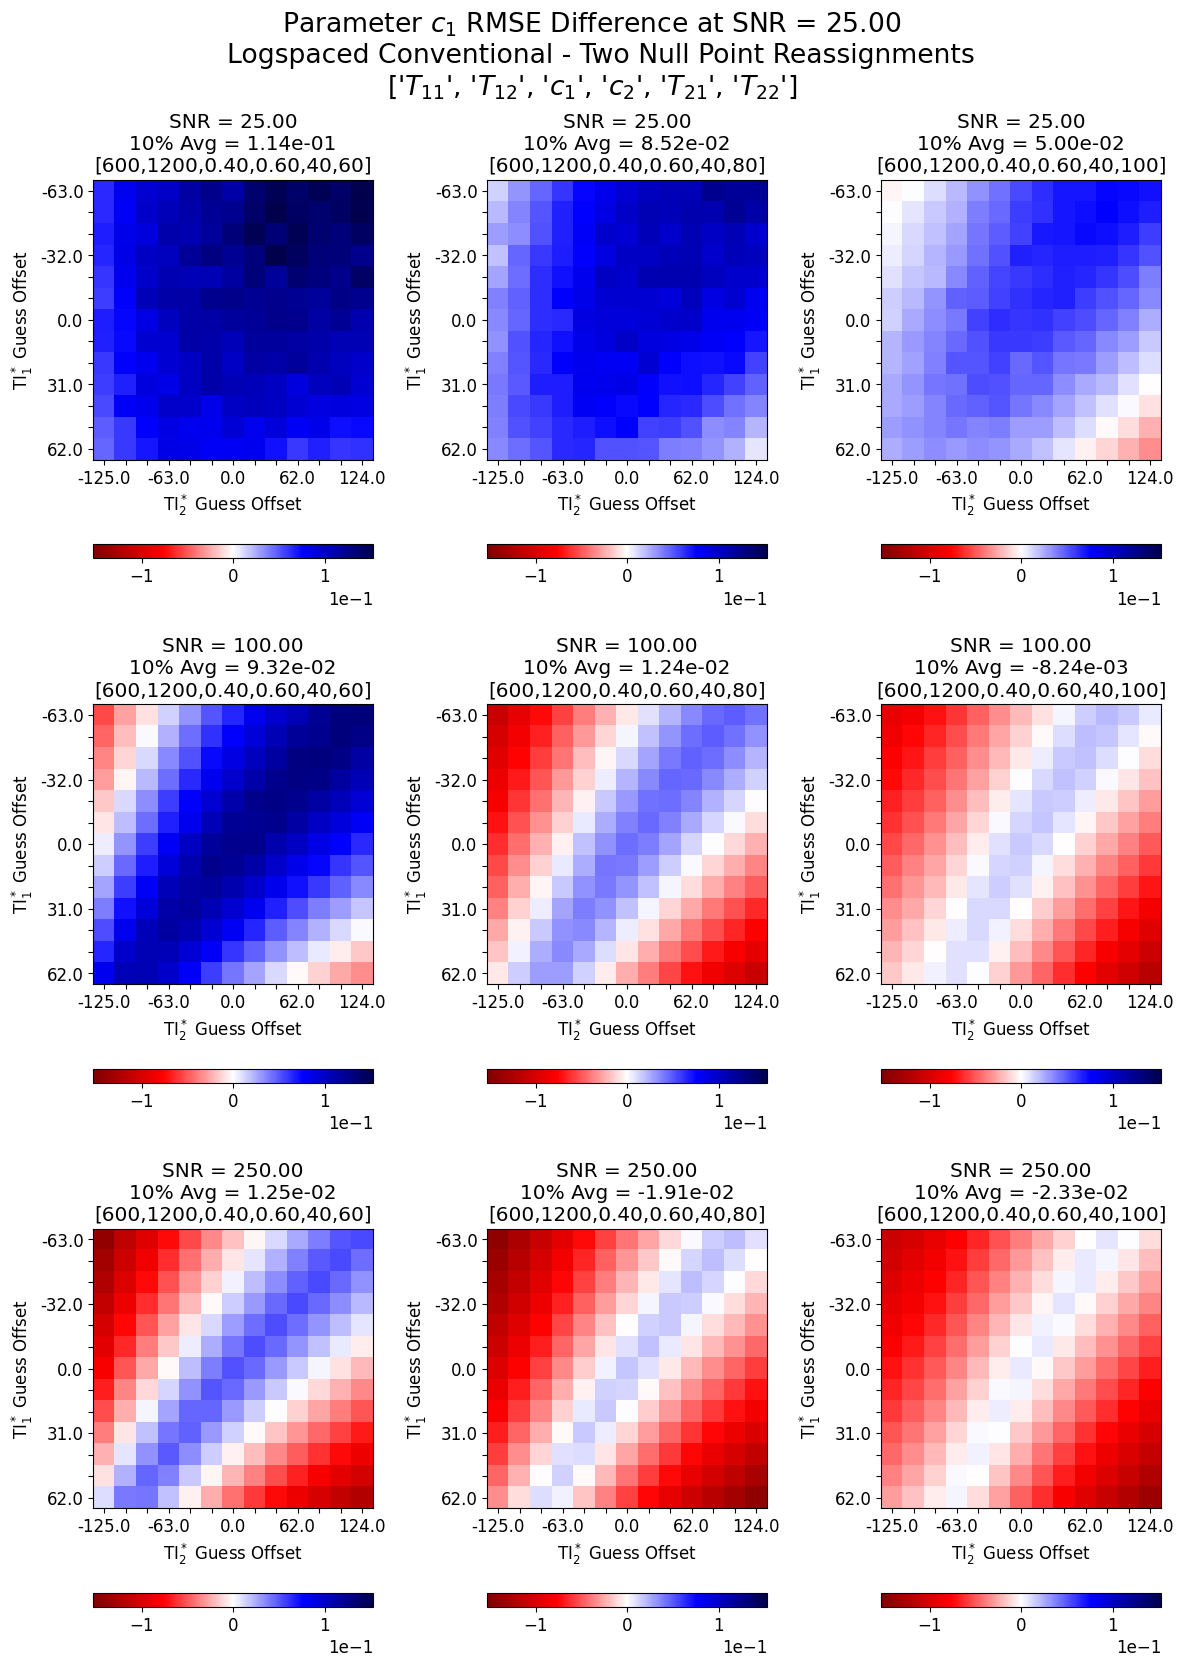

In [13]:
fig, ax = plt.subplots(3,3, figsize = (12, 17), tight_layout=True)
plt.rc('font', size = 16)
fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} RMSE Difference at SNR = {SNR_array[SNR_index_oi] :0.2f}\n  Logspaced Conventional - Two Null Point Reassignments\n{ParamTitle_6p}")
plt.rc('font', size = 12)

max_val = 0

SNR_short_array = [0, -4, -2]
for iSNR in range(len(SNR_short_array)):
    SNR_index_oi = SNR_short_array[iSNR]
    SNR_temp_value = SNR_array[SNR_index_oi]
    T2_short_array = [0, len(T2rat_array)//2, -1]
    for iT2 in range(len(T2_short_array)):

        mat1 = np.where(SNR_array[SNR_index_oi] == SR_SNR)[0]
        mat2 = np.where(T2rat_array[T2_short_array[iT2]] == SR_T2Rat)[0]
        SR_index_match = np.intersect1d(mat1,mat2)[0]

        temp_SR_MSE = SR_MSE[SR_index_match,param_oi]

        temp_MSE_imp = temp_SR_MSE**(1/2)-MSE[:, : , T2_short_array[iT2], SNR_index_oi, 0]**(1/2)

        if np.max(temp_MSE_imp)>max_val:
            max_val = np.max(temp_MSE_imp)



SNR_short_array = [0, -4, -2]
for iSNR in range(len(SNR_short_array)):
    SNR_index_oi = SNR_short_array[iSNR]
    SNR_temp_value = SNR_array[SNR_index_oi]
    T2_short_array = [0, len(T2rat_array)//2, -1]
    for iT2 in range(len(T2_short_array)):

        mat1 = np.where(SNR_array[SNR_index_oi] == SR_SNR)[0]
        mat2 = np.where(T2rat_array[T2_short_array[iT2]] == SR_T2Rat)[0]
        SR_index_match = np.intersect1d(mat1,mat2)[0]

        temp_SR_MSE = SR_MSE[SR_index_match,param_oi]

        temp_MSE_imp = temp_SR_MSE**(1/2)-MSE[:, : , T2_short_array[iT2], SNR_index_oi, 0]**(1/2)

        tenAvg = np.mean(temp_MSE_imp[tenD:tenU, tenD:tenU])

        gen_patchwork_panel(fig, ax[iSNR, iT2%3], T2rat_array[T2_short_array[iT2]], temp_MSE_imp, ex_title=f'SNR = {SNR_temp_value:.2f}\n10% Avg = {tenAvg:.2e}\n', cb_range = max_val)


### Paper Figure

In [14]:
sp_map = plt.get_cmap('seismic_r')
sp_map.set_extremes(under = 'orange')
extend_opt = "neither"      #max or neither

def gen_patchwork_panel_final(fig, ax, T2_rat, imp_mat, ex_title='', cb_range = 0):
    ######## bottom left

    if cb_range == 0:
        pos_max = np.max(imp_mat)
    else:
        pos_max = cb_range
    T22 = T2_rat*T21

    # plt.rc('font', size = 12)
    ax.set_title(f"{ex_title}")
    # ax.set_title(f"{ex_title}[{T11:.0f},{T12:.0f},{c1:.2f},{c2:.2f},{T21:.0f},{T22:.0f}]")
    # ax.set_title('Improvement in ' + param_name_list[POI] + ' MSE')
    imc1 = ax.imshow(imp_mat[:,:], cmap = sp_map, vmin = -1*pos_max, vmax = pos_max)

    
    ax.set_xticks(np.arange(len(np2_array)))
    ax.set_yticks(np.arange(len(np1_array)))

    percent_list = ['-15%', '-12.5%', '-10%', '-7.5%', '-5%', '-2.5%', '0%', '2.5%', '5%', '7.5%', '10%', '12.5%', '15%']

    temp_x_labels = ["" for a in np2_array]
    x_array = [0,len(np2_array)//4,len(np2_array)//2, 3*len(np2_array)//4, -1]
    for elem in x_array:
        temp_x_labels[elem] = f"{percent_list[elem]}"
    ax.set_xticklabels(temp_x_labels)

    temp_y_labels = ["" for a in np1_array]
    y_array = [0,len(np1_array)//4,len(np1_array)//2, 3*len(np1_array)//4, -1]
    for elem in y_array:
        temp_y_labels[elem] = f"{percent_list[elem]}"
    ax.set_yticklabels(temp_y_labels)

    ax.set_ylabel(r'TI$_1^*$ Percent Offset: TI$_{1,g}^*$')
    ax.set_xlabel(r'TI$_2^*$ Percent Offset: TI$_{2,g}^*$')
    plt.rc('font', size = 12)
    # cbar = fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.2, location = 'bottom', extend = extend_opt)#, format = '%.2e')
    # cbar.formatter.set_powerlimits((0,0))

    return imc1

Text(0, 0.12, 'SNR = 250')

/home/hamptong2/Stabilization/.venv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)


/home/hamptong2/Stabilization/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


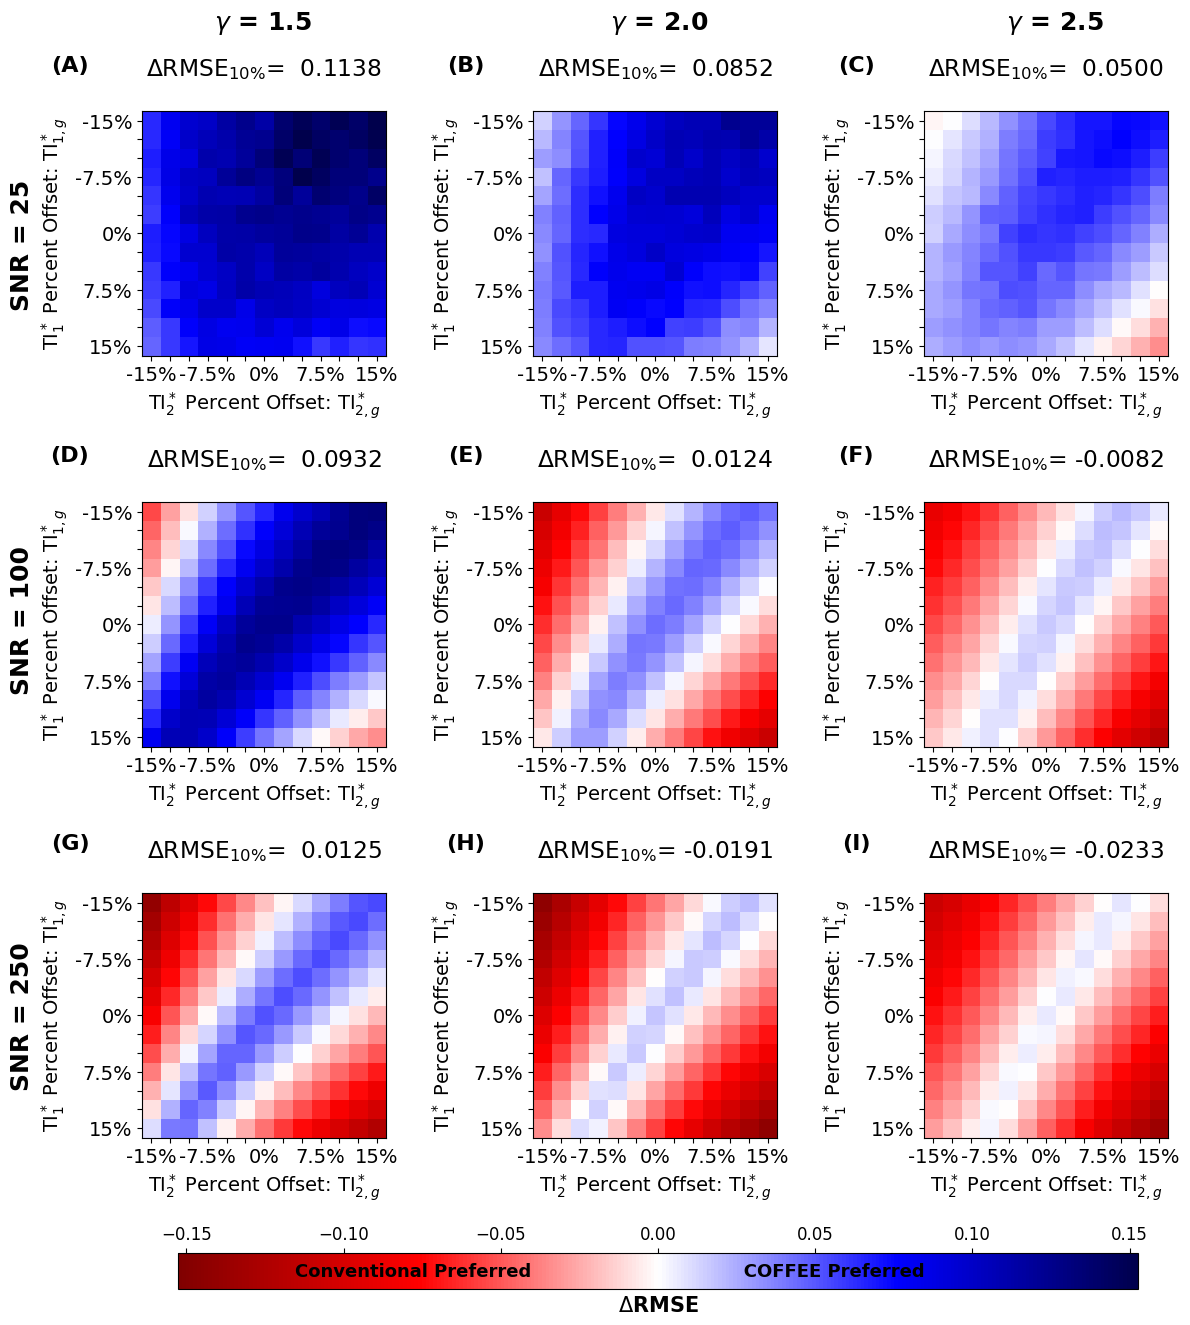

In [46]:
plt.rc('font', size = 14)
fig, ax = plt.subplots(3,3, figsize = (12, 12), tight_layout=True)
plt.rc('font', size = 14)
# fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} RMSE Difference at SNR = {SNR_array[SNR_index_oi] :0.2f}\n  Logspaced Conventional - Two Null Point Reassignments\n{ParamTitle_6p}")


max_val = 0

SNR_short_array = [0, -4, -2]
for iSNR in range(len(SNR_short_array)):
    SNR_index_oi = SNR_short_array[iSNR]
    SNR_temp_value = SNR_array[SNR_index_oi]
    T2_short_array = [0, len(T2rat_array)//2, -1]
    for iT2 in range(len(T2_short_array)):

        mat1 = np.where(SNR_array[SNR_index_oi] == SR_SNR)[0]
        mat2 = np.where(T2rat_array[T2_short_array[iT2]] == SR_T2Rat)[0]
        SR_index_match = np.intersect1d(mat1,mat2)[0]

        temp_SR_MSE = SR_MSE[SR_index_match,param_oi]

        temp_MSE_imp = temp_SR_MSE**(1/2)-MSE[:, : , T2_short_array[iT2], SNR_index_oi, 0]**(1/2)

        if np.max(temp_MSE_imp)>max_val:
            max_val = np.max(temp_MSE_imp)

for iSNR in range(len(SNR_short_array)):
    SNR_index_oi = SNR_short_array[iSNR]
    SNR_temp_value = SNR_array[SNR_index_oi]
    T2_short_array = [0, len(T2rat_array)//2, -1]
    for iT2 in range(len(T2_short_array)):

        mat1 = np.where(SNR_array[SNR_index_oi] == SR_SNR)[0]
        mat2 = np.where(T2rat_array[T2_short_array[iT2]] == SR_T2Rat)[0]
        SR_index_match = np.intersect1d(mat1,mat2)[0]

        temp_SR_MSE = SR_MSE[SR_index_match,param_oi]

        temp_MSE_imp = temp_SR_MSE**(1/2)-MSE[:, : , T2_short_array[iT2], SNR_index_oi, 0]**(1/2)

        tenAvg = np.mean(temp_MSE_imp[tenD:tenU, tenD:tenU])

        plt.rc('font', size = 14)
        imc_hold = gen_patchwork_panel_final(fig, ax[iSNR, iT2%3], T2rat_array[T2_short_array[iT2]], temp_MSE_imp, ex_title=r'$\Delta$RMSE$_{10\%}$' + f'= {tenAvg: .4f}\n', cb_range = max_val)

#ex_title=f'SNR = {SNR_temp_value:.2f}\n10% Avg = {tenAvg:.2e}\n'

cbar_ax = fig.add_axes([0.14, -0.05, 0.8, 0.03])
cbar = fig.colorbar(imc_hold, cax=cbar_ax, orientation = 'horizontal', location = 'top', extend = extend_opt)#, format = '%.2e')
# cbar.formatter.set_powerlimits((0,0))
cbar.set_label(label=r'$\Delta$RMSE',size=15, weight='bold')
cbar.ax.xaxis.set_label_position('bottom')
fig.text(0.5, -0.039, "Conventional Preferred                                  COFFEE Preferred", ha = 'center', size=13, weight = 'bold')


plt.rc('font', size = 16)
fig.text(0.05,0.97, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.97, '(B)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.97, '(C)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.05,0.645, '(D)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.645, '(E)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.645, '(F)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.05,0.322, '(G)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.322, '(H)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.322, '(I)', ha="center", va="center", color="black", weight = "bold")
plt.rc('font', size = 18)
fig.text(0.17,1,r'$\gamma$ = 1.5', weight = 'bold')
fig.text(0.5,1,r'$\gamma$ = 2.0', weight = 'bold')
fig.text(0.83,1,r'$\gamma$ = 2.5', weight = 'bold')
fig.text(0, 0.77 ,r'SNR = 25', rotation = 'vertical', weight = 'bold')
fig.text(0, 0.45 ,r'SNR = 100', rotation = 'vertical', weight = 'bold')
fig.text(0, 0.12 ,r'SNR = 250', rotation = 'vertical', weight = 'bold')

2.0000000000000004
0.003640937730821712
(13, 13, 11, 8, 3)
2
10
$\Delta$RMSE$_{10\%}$=  0.0124


Text(0.3, -0.055, 'Conventional\nPreferred')

/home/hamptong2/Stabilization/.venv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/hamptong2/Stabilization/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


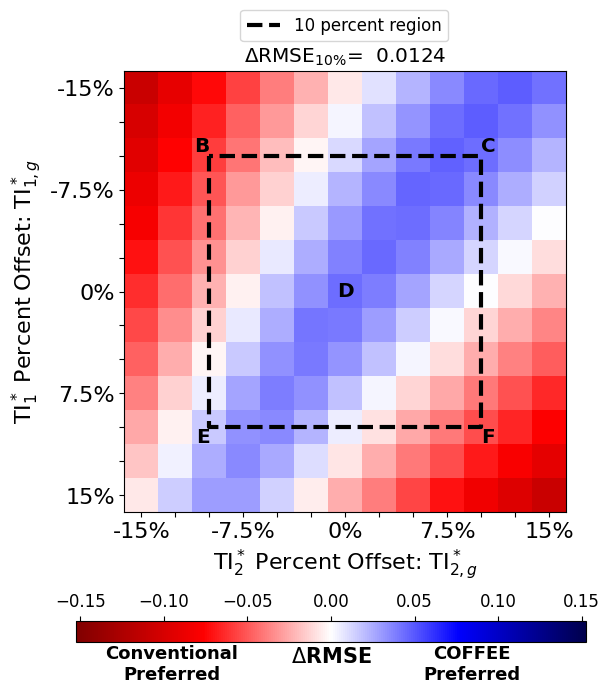

In [16]:
SNR_index_oi = -4
T2rat_index_oi = 5

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize = (6, 7), tight_layout=True)
# fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} RMSE Difference at SNR = {SNR_array[SNR_index_oi] :0.2f}\n Logspaced Conventional - Two Null Point Reassignments\n{ParamTitle_6p}")

mat1 = np.where(SNR_array[SNR_index_oi] == SR_SNR)[0]
mat2 = np.where(T2rat_array[T2rat_index_oi] == SR_T2Rat)[0]
SR_index_match = np.intersect1d(mat1,mat2)[0]

temp_SR_MSE = SR_MSE[SR_index_match,param_oi]

print(T2rat_array[T2rat_index_oi])
print(temp_SR_MSE)
print(MSE.shape)

temp_MSE_imp = temp_SR_MSE**(1/2)-MSE[:, : , T2rat_index_oi, SNR_index_oi, 0]**(1/2)

# temp_max = np.max(np.abs(temp_MSE_imp))

gen_patchwork_panel_final(fig, ax, T2rat_array[T2rat_index_oi], temp_MSE_imp, cb_range = max_val)
tenD = np.where(np.abs(np1_array/TI1star - -0.1) < 0.003)[0][0]
tenU = np.where(np.abs(np1_array/TI1star - 0.1) < 0.003)[0][0]
print(tenD)
print(tenU)
ax.plot([tenD, tenD, tenU, tenU, tenD],[tenD, tenU, tenU, tenD, tenD], ls = '--', color = 'k', lw = 3, label = '10 percent region')
# ax.legend()
# ax_MSE[1,2].remove()

ex_area = np.mean(temp_MSE_imp[tenD:tenU, tenD:tenU])#trapz_3d(np1_array[tenD:tenU], np2_array[tenD:tenU], temp_MSE_imp[tenD:tenU, tenD:tenU])
print(r'$\Delta$RMSE$_{10\%}$' + f'= {ex_area: .4f}')
ax.set_title(r'$\Delta$RMSE$_{10\%}$' + f'= {ex_area: .4f}')
ax.text(tenD,tenD, "B", fontsize = 'large', fontweight = 'bold', ha = 'right', va = 'bottom')
ax.text(tenU,tenD, "C", fontsize = 'large', fontweight = 'bold', ha = 'left', va = 'bottom')
ax.text(tenD,tenU, "E", fontsize = 'large', fontweight = 'bold', ha = 'right', va = 'top')
ax.text(tenU,tenU, "F", fontsize = 'large', fontweight = 'bold', ha = 'left', va = 'top')
ax.text(len(np1_array)//2,len(np2_array)//2, "D", fontsize = 'large', fontweight = 'bold', ha = 'center', va = 'center')
fig.legend(loc = 'center left', bbox_to_anchor = (0.4,0.88))

cbar_ax = fig.add_axes([0.14, 0, 0.85, 0.03])
cbar = fig.colorbar(imc_hold, cax=cbar_ax, orientation = 'horizontal', location = 'top', extend = extend_opt)#, format = '%.2e')
# cbar.formatter.set_powerlimits((0,0))
cbar.set_label(label=r'$\Delta$RMSE',size=15, weight='bold')
cbar.ax.xaxis.set_label_position('bottom')
fig.text(0.8, -0.055, "COFFEE\nPreferred", ha = 'center', size=13, weight = 'bold')
fig.text(0.3, -0.055, "Conventional\nPreferred", ha = 'center', size=13, weight = 'bold')

In [17]:
SNR_vs_rat_mat = np.zeros((len(SNR_array), len(T2rat_array)))

for iSNR in range(len(SNR_array)):
    for iT2 in range(len(T2rat_array)):

        mat1 = np.where(SNR_array[iSNR] == SR_SNR)[0]
        mat2 = np.where(T2rat_array[iT2] == SR_T2Rat)[0]
        SR_index_match = np.intersect1d(mat1,mat2)[0]

        temp_SR_MSE = SR_MSE[SR_index_match,param_oi]

        temp_MSE_imp = temp_SR_MSE**(1/2)-MSE[:, : , iT2, iSNR, 0]**(1/2)

        SNR_vs_rat_mat[iSNR, iT2] = np.mean(temp_MSE_imp[tenD:tenU, tenD:tenU])#trapz_3d(np1_array[tenD:tenU], np2_array[tenD:tenU], temp_MSE_imp[tenD:tenU, tenD:tenU])

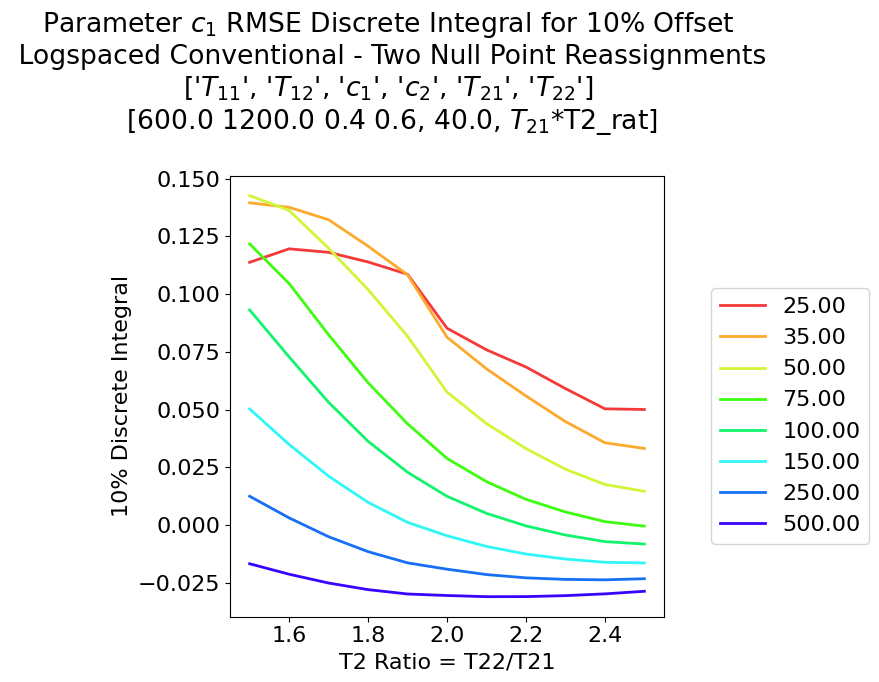

In [18]:
colors_list = _get_colors(len(SNR_array) + 2)

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize = (6, 7), tight_layout=True)
fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} RMSE Discrete Integral for 10% Offset\n Logspaced Conventional - Two Null Point Reassignments\n{ParamTitle_6p}\n [{T11} {T12} {c1} {c2}, {T21}, {ParamTitle_6p[-2]}*T2_rat]")

for iSNR in range(len(SNR_array)):
    ax.plot(T2rat_array, SNR_vs_rat_mat[iSNR,:], color = colors_list[iSNR], ls = '-', lw = 2, label = f"{SNR_array[iSNR]:.2f}")

ax.set_ylabel("10% Discrete Integral")
ax.set_xlabel("T2 Ratio = T22/T21")
fig.legend(loc = 'center left', bbox_to_anchor = (1.02,0.4))

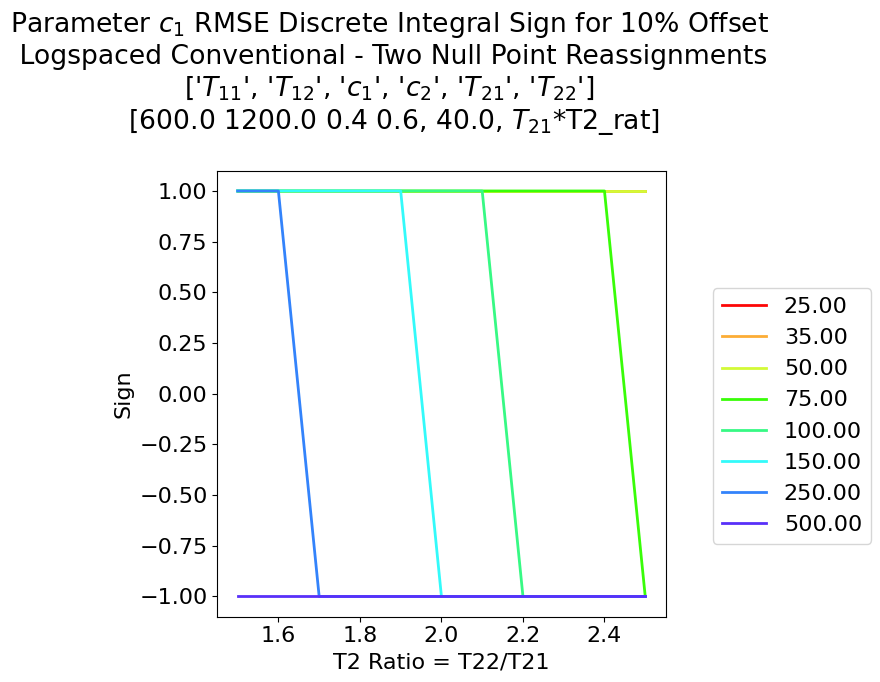

In [19]:
colors_list = _get_colors(len(SNR_array) + 2)

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize = (6, 7), tight_layout=True)
fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} RMSE Discrete Integral Sign for 10% Offset\n Logspaced Conventional - Two Null Point Reassignments\n{ParamTitle_6p}\n [{T11} {T12} {c1} {c2}, {T21}, {ParamTitle_6p[-2]}*T2_rat]")

for iSNR in range(len(SNR_array)):
    ax.plot(T2rat_array, np.sign(SNR_vs_rat_mat[iSNR,:]), color = colors_list[iSNR], ls = '-', lw = 2, label = f"{SNR_array[iSNR]:.2f}")

ax.set_ylabel("Sign")
ax.set_xlabel("T2 Ratio = T22/T21")
fig.legend(loc = 'center left', bbox_to_anchor = (1.02,0.4))

Maximum Change in 10% RMSE = 0.14267990628813484
Minimum Change in 10% RMSE = -0.03102429040252979


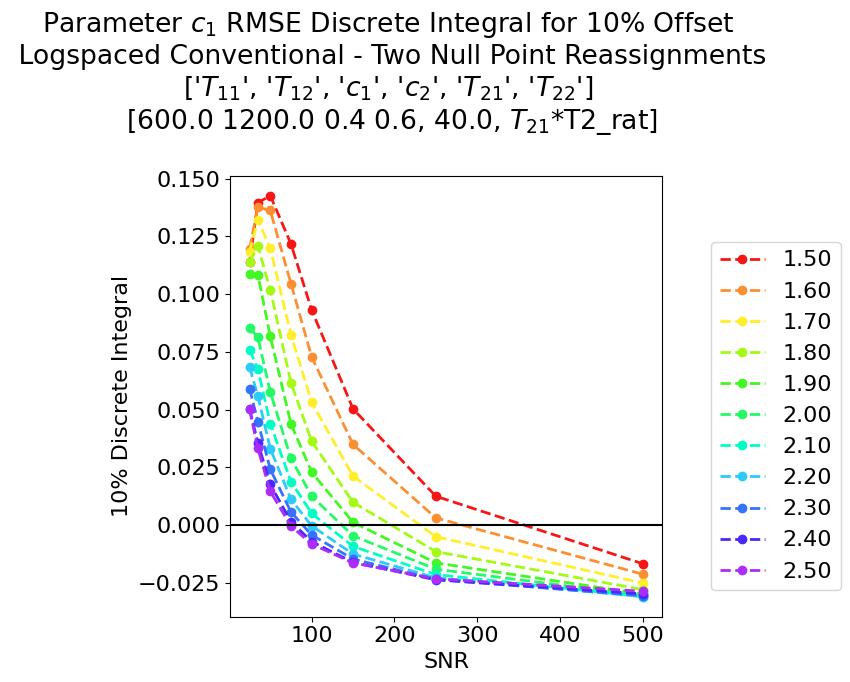

In [20]:
colors_list = _get_colors(len(T2rat_array) + 2)

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize = (6, 7), tight_layout=True)
fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} RMSE Discrete Integral for 10% Offset\n Logspaced Conventional - Two Null Point Reassignments\n{ParamTitle_6p}\n [{T11} {T12} {c1} {c2}, {T21}, {ParamTitle_6p[-2]}*T2_rat]")

for iT2 in range(len(T2rat_array)):
    ax.plot(SNR_array, SNR_vs_rat_mat[:, iT2], color = colors_list[iT2], ls = '--', marker = 'o', lw = 2, label = f"{T2rat_array[iT2]:.2f}")

ax.axhline(y = 0, color = 'k') 

ax.set_ylabel("10% Discrete Integral")
ax.set_xlabel("SNR")
fig.legend(loc = 'center left', bbox_to_anchor = (1.02,0.4))

print(f"Maximum Change in 10% RMSE = {np.max(SNR_vs_rat_mat)}")
print(f"Minimum Change in 10% RMSE = {np.min(SNR_vs_rat_mat)}")

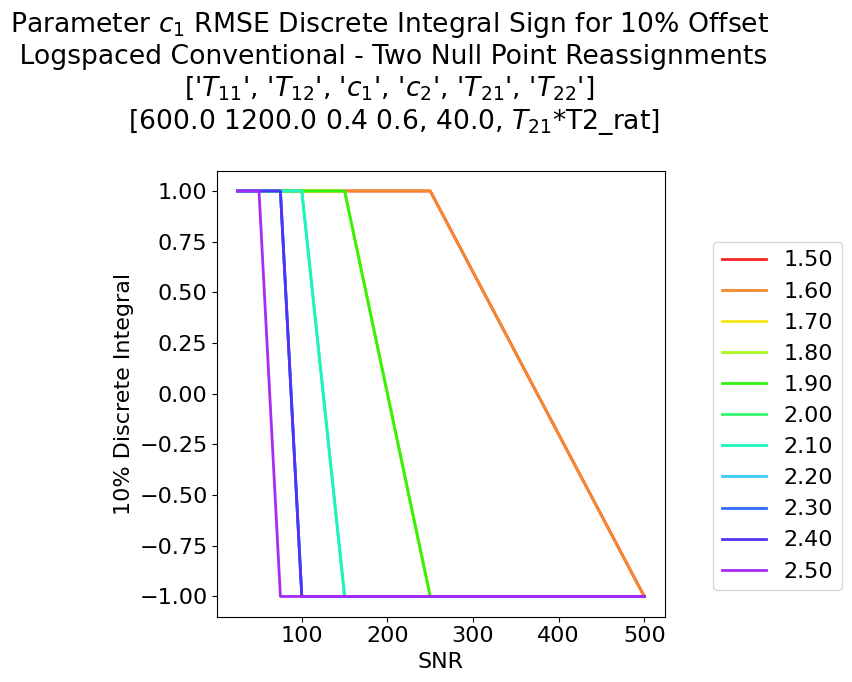

In [21]:
colors_list = _get_colors(len(T2rat_array) + 2)

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize = (6, 7), tight_layout=True)
fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} RMSE Discrete Integral Sign for 10% Offset\n Logspaced Conventional - Two Null Point Reassignments\n{ParamTitle_6p}\n [{T11} {T12} {c1} {c2}, {T21}, {ParamTitle_6p[-2]}*T2_rat]")

for iT2 in range(len(T2rat_array)):
    ax.plot(SNR_array, np.sign(SNR_vs_rat_mat[:, iT2]), color = colors_list[iT2], ls = '-', lw = 2, label = f"{T2rat_array[iT2]:.2f}")

ax.set_ylabel("10% Discrete Integral")
ax.set_xlabel("SNR")
fig.legend(loc = 'center left', bbox_to_anchor = (1.02,0.4))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


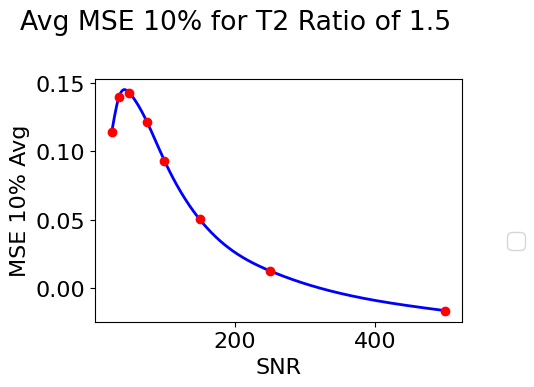

In [22]:
T2rat_index_oi = 0
poly_T2rat_cs = scipy.interpolate.make_smoothing_spline(SNR_array, SNR_vs_rat_mat[:, T2rat_index_oi])
SNR_dense_array = np.arange(SNR_array[0],500,1)
MSE10_dense = poly_T2rat_cs(SNR_dense_array)

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize = (5, 4), tight_layout=True)
fig.suptitle(f"Avg MSE 10% for T2 Ratio of {T2rat_array[T2rat_index_oi]}")


ax.plot(SNR_dense_array, MSE10_dense, color = 'b', ls = '-', lw = 2)
ax.plot(SNR_array, SNR_vs_rat_mat[:, T2rat_index_oi], color = 'r', ls = '', lw = 2, marker = 'o')

ax.set_ylabel("MSE 10% Avg")
ax.set_xlabel("SNR")
fig.legend(loc = 'center left', bbox_to_anchor = (1.02,0.4))

In [23]:
x_intersection = np.zeros(len(T2rat_array))
SNR_dense_array = np.arange(SNR_array[0],SNR_array[-1],1)
line_fits = np.zeros((len(T2rat_array),len(SNR_dense_array)))

for iT2 in range(len(T2rat_array)):

    poly_T2rat_cs = scipy.interpolate.make_smoothing_spline(SNR_array, SNR_vs_rat_mat[:, iT2])
    x_intersection[iT2] = scipy.optimize.fsolve(poly_T2rat_cs, 100)

    line_fits[iT2,:] = poly_T2rat_cs(SNR_dense_array)
    

/tmp/ipykernel_2136/3371902074.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_intersection[iT2] = scipy.optimize.fsolve(poly_T2rat_cs, 100)


Exponential Parameters
a::8.60e+03::b::2.29e+00::g::4.35e+01
Inverse Parameters
a::2.13e+02::b::-9.58e-01::g::-7.01e+01


Text(0.5, 0, '$T_2$ Ratio')

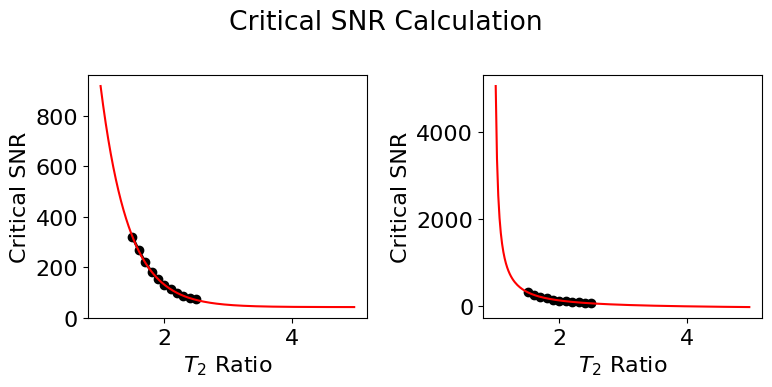

In [24]:
def exp_fit(T2_rat, alpha, beta, gamma):
    return alpha*np.exp(-beta*T2_rat)+gamma

def inv_fit(T2_rat, alpha, beta, gamma):
    return alpha/(T2_rat+beta)+gamma

popt_exp, _ = scipy.optimize.curve_fit(exp_fit, T2rat_array, x_intersection, p0 = [500, 1, 50])

popt_inv, _ = scipy.optimize.curve_fit(inv_fit, T2rat_array, x_intersection, p0 = [500, 1, 50])

T2_rat_interp = np.arange(1,5,0.02)

print("Exponential Parameters")
print(f"a::{popt_exp[0]:0.2e}::b::{popt_exp[1]:0.2e}::g::{popt_exp[2]:0.2e}")

print("Inverse Parameters")
print(f"a::{popt_inv[0]:0.2e}::b::{popt_inv[1]:0.2e}::g::{popt_inv[2]:0.2e}")

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,2, figsize = (8, 4), tight_layout=True)
fig.suptitle(f"Critical SNR Calculation")

ax[0].plot(T2rat_array, x_intersection, color = 'k', ls = '-', marker = 'o', lw = 2)
ax[0].plot(T2_rat_interp, exp_fit(T2_rat_interp, *popt_exp), color = 'r')
ax[0].set_ylabel("Critical SNR")
ax[0].set_xlabel(r'$T_2$ Ratio')


ax[1].plot(T2rat_array, x_intersection, color = 'k', ls = '-', marker = 'o', lw = 2)
ax[1].plot(T2_rat_interp, inv_fit(T2_rat_interp, *popt_inv), color = 'r')
ax[1].set_ylabel("Critical SNR")
ax[1].set_xlabel(r'$T_2$ Ratio')

Text(0.5, 1.0, 'R^2 = 0.9863')

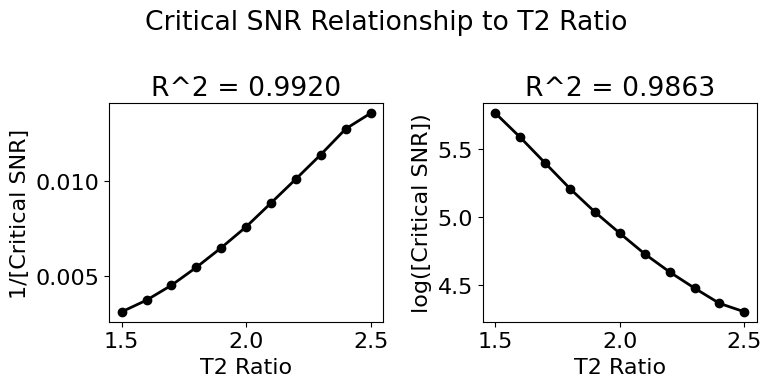

In [25]:
plt.rc('font', size = 16)
fig, ax = plt.subplots(1,2, figsize = (8, 4), tight_layout=True)
fig.suptitle(f"Critical SNR Relationship to T2 Ratio")


ax[0].plot(T2rat_array, 1/(x_intersection), color = 'k', ls = '-', marker = 'o', lw = 2)

pinv_fit = np.polyfit(T2rat_array, 1/(x_intersection), 1)
inv_pred = pinv_fit[0]*(T2rat_array)+pinv_fit[1]
inv_coefMat = np.corrcoef(1/(x_intersection),inv_pred)
inv_coefDet = inv_coefMat[0,1]**2

ax[0].set_ylabel("1/[Critical SNR]")
ax[0].set_xlabel("T2 Ratio")
ax[0].set_title(f"R^2 = {inv_coefDet:.4f}")

ax[1].plot(T2rat_array, np.log(x_intersection), color = 'k', ls = '-', marker = 'o', lw = 2)

pexp_fit = np.polyfit(T2rat_array, np.log(x_intersection), 1)
exp_pred = pexp_fit[0]*(T2rat_array)+pexp_fit[1]
exp_coefMat = np.corrcoef(np.log(x_intersection),exp_pred)
exp_coefDet = exp_coefMat[0,1]**2

ax[1].set_ylabel("log([Critical SNR])")
ax[1].set_xlabel("T2 Ratio")
ax[1].set_title(f"R^2 = {exp_coefDet:.4f}")

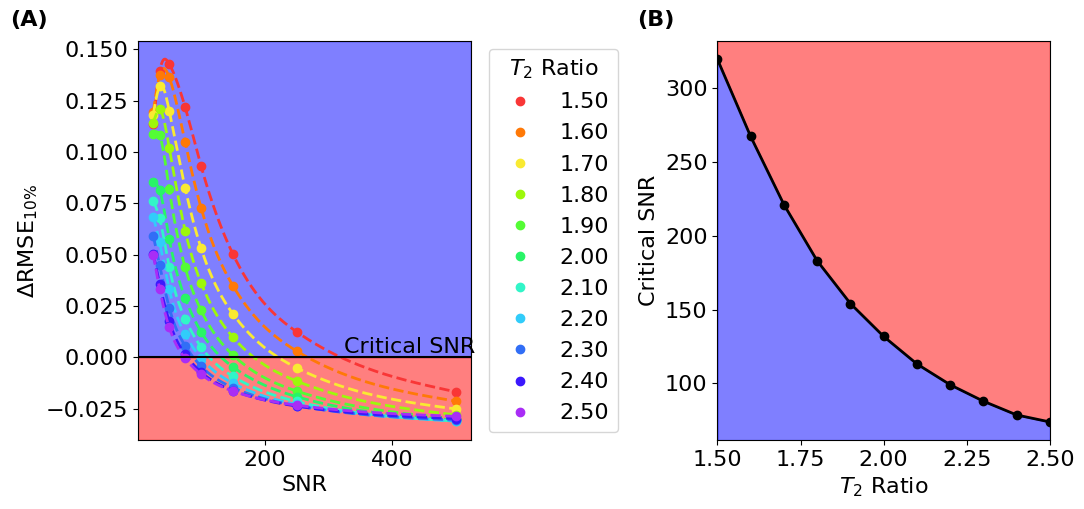

In [26]:
colors_list = _get_colors(len(T2rat_array) + 2)

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,2, figsize = (11, 5), tight_layout=True)
# fig.suptitle(f"Critical SNR Calculation")

for iT2 in range(len(T2rat_array)):
    ax[0].plot(SNR_dense_array, line_fits[iT2,:], color = colors_list[iT2], ls = '--', lw = 2)
    ax[0].plot(SNR_array, SNR_vs_rat_mat[:, iT2], color = colors_list[iT2], ls = '', marker = 'o', lw = 2, label = f"{T2rat_array[iT2]:.2f}")

ax[0].axhline(y = 0, color = 'k')
ax[0].text(325,0,"Critical SNR", fontsize = 16, ha = 'left', va = 'bottom') 
ax[0].set_ylabel(r'$\Delta$RMSE$_{10\%}$')
ax[0].set_xlabel("SNR")
ax[0].legend(loc = 'center left', bbox_to_anchor = (1.02,0.5), title = r'$T_2$ Ratio')
ax[0].axhspan(0, ax[0].get_ylim()[-1], color = 'blue', alpha = 0.5)
ax[0].axhspan(ax[0].get_ylim()[0], 0, color = 'red', alpha = 0.5)
ax[0].autoscale(enable = True, axis = 'y', tight = True)

T2_rat_interp = np.arange(T2rat_array[0], T2rat_array[-1], 0.02)

ax[1].plot(T2rat_array, x_intersection, color = 'k', ls = '-', marker = 'o', lw = 2)
ax[1].set_ylabel("Critical SNR")
ax[1].set_xlabel(r'$T_2$ Ratio')
ylim_ar = ax[1].get_ylim()
upper_boundary = np.ones(len(T2rat_array))*ylim_ar[-1]
lower_boundary = np.ones(len(T2rat_array))*ylim_ar[0]
ax[1].fill_between(T2rat_array, x_intersection, upper_boundary, color = 'red', alpha = 0.5) 
ax[1].fill_between(T2rat_array, x_intersection, lower_boundary, color = 'blue', alpha = 0.5) 
# ax[1].plot(T2_rat_interp, exp_fit(T2_rat_interp, *popt_exp), color = 'r')
ax[1].autoscale(enable = True, axis = 'x', tight = True)
ax[1].set_ylim(ylim_ar)

plt.rc('font', size = 16)
fig.text(0.03,1, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.6,1, '(B)', ha="center", va="center", color="black", weight = "bold")
plt.rc('font', size = 14)

In [27]:
# mat_oi = SNRs

# eqT_map = plt.get_cmap('turbo')
# eqT_map.set_extremes(over = 'blue')
# extend_opt = "max"      #max or none

# plt.rc('font', size = 16)
# fig, ax = plt.subplots(1,1, figsize = (5, 5), tight_layout=True)
# fig.suptitle(f"Equal Time Influence on SNR")

# plt.rc('font', size = 16)
# ax.set_title(f"SNR = {SNR_value}")
# imc1 = ax.imshow(mat_oi, cmap = eqT_map)

# # ax.set_title('Improvement in ' + param_name_list[POI] + ' MSE')
# ax.set_xticks(np.arange(len(np2_array)))
# ax.set_yticks(np.arange(len(np1_array)))

# temp_x_labels = ["" for a in np2_array]
# x_array = [0,len(np2_array)//4,len(np2_array)//2, 3*len(np2_array)//4, -1]
# for elem in x_array:
#     temp_x_labels[elem] = f"{np2_array[elem]:0.1f}"
# ax.set_xticklabels(temp_x_labels)

# temp_y_labels = ["" for a in np1_array]
# y_array = [0,len(np1_array)//4,len(np1_array)//2, 3*len(np1_array)//4, -1]
# for elem in y_array:
#     temp_y_labels[elem] = f"{np1_array[elem]:0.1f}"
# ax.set_yticklabels(temp_y_labels)

# ax.set_ylabel(r'TI$_1^*$ Guess Offset')
# ax.set_xlabel(r'TI$_2^*$ Guess Offset')
# plt.rc('font', size = 12)
# cbar = fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.2, location = 'bottom', extend = extend_opt)#, format = '%.2e')
# # cbar.formatter.set_powerlimits((0,0))

# Example Pixel Histograms

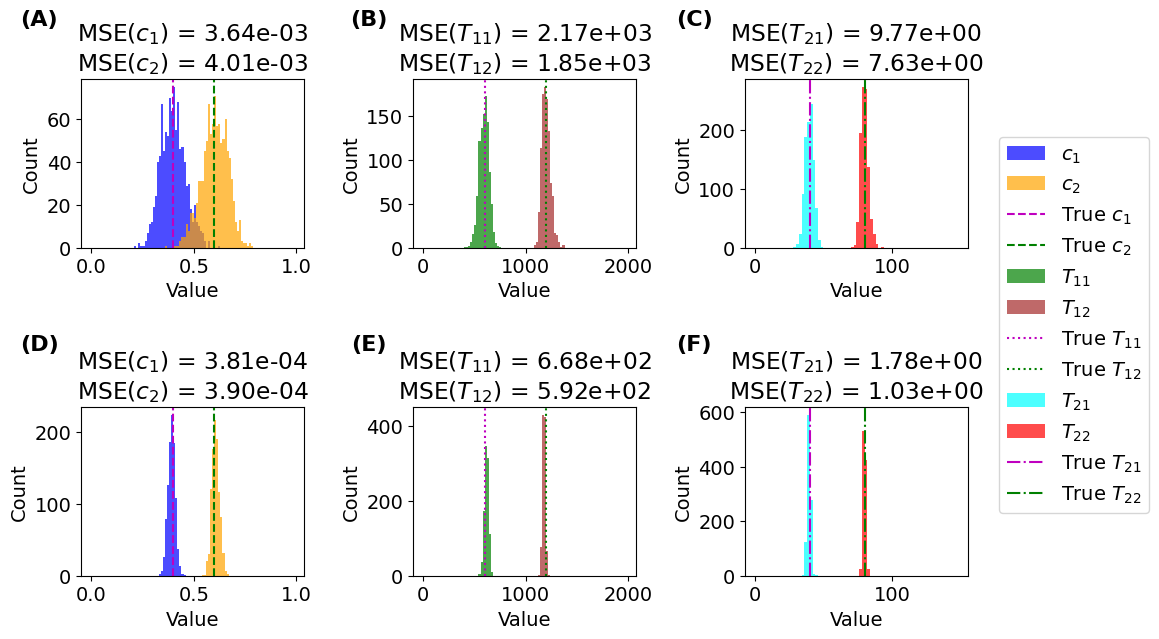

In [28]:
SNR_index_oi = -4
T2rat_index_oi = 5

center_oi_list = np.array([[len(np1_array)//2+1,len(np2_array)//2-1]])#[0,0],[ 0,-1],[ -1,-1],[ -1, 0],])
hist_titles = ["top left", "top right", "bottom right", "bottom left", "center"]

mat1 = np.where(SNR_array[SNR_index_oi] == SR_SNR)[0]
mat2 = np.where(T2rat_array[T2rat_index_oi] == SR_T2Rat)[0]
SR_index_match = np.intersect1d(mat1,mat2)[0]

T2rat_true_params = [T11, T12, c1, c2, T21, T2rat_array[T2rat_index_oi]*T21]

for iter in range(len(center_oi_list)):
    center1_ioi = center_oi_list[iter,0]
    center2_ioi = center_oi_list[iter,1]
    plt.rc('font', size = 14)

    fig, ax = plt.subplots(2, 3, figsize=(10, 6.5), tight_layout=True)
    # fig.suptitle(f"Parameter Estimates at Specific Null Point Guess\nNull Point 1 = {np1_array[center1_ioi]} :: Null Point 2 = {np2_array[center2_ioi]}\n{var_reps} Iterations :: SNR = {SNR_array[SNR_index_oi] :0.2f}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T21*T2rat_array[T2rat_index_oi]:.0f}]")


    MSEMat, varMat, sqBMat = calc_MSE(pEst_AIC[center1_ioi, center2_ioi, T2rat_index_oi, SNR_index_oi, :, :], T2rat_true_params)

    bin_array = np.arange(0, 1, 0.01)
    ax[1,0].hist(x=pEst_AIC[center1_ioi, center2_ioi, T2rat_index_oi, SNR_index_oi, :,-4], bins=bin_array, color='b', alpha = 0.7)
    ax[1,0].hist(x=pEst_AIC[center1_ioi, center2_ioi, T2rat_index_oi, SNR_index_oi,:,-3], bins=bin_array, color='orange', alpha = 0.7)
    ax[1,0].axvline(x = true_params[2], color='m', ls = '--')
    ax[1,0].axvline(x = true_params[3], color='g', ls = '--')
    ax[1,0].set_xlabel('Value')
    ax[1,0].set_ylabel('Count')
    ax[1,0].set_title(f"\nMSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")

    ymin, ymax = ax[1,0].get_ylim()
    xmin, xmax = ax[1,0].get_xlim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    # ax[1,0].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
    # ax[1,0].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

    bin_array = np.arange(0, 2000, 20)
    ax[1,1].hist(x=pEst_AIC[center1_ioi, center2_ioi, T2rat_index_oi, SNR_index_oi,:,0], bins=bin_array, color='g', alpha = 0.7)
    ax[1,1].hist(x=pEst_AIC[center1_ioi, center2_ioi, T2rat_index_oi, SNR_index_oi,:,1], bins=bin_array, color='brown', alpha = 0.7)
    ax[1,1].axvline(x = true_params[0], color='m', ls = ':')
    ax[1,1].axvline(x = true_params[1], color='g', ls = ':')
    ax[1,1].set_xlabel('Value')
    ax[1,1].set_ylabel('Count')
    ax[1,1].set_title(f"MSE({ParamTitle_6p[0]}) = {MSEMat[0]:.2e}\nMSE({ParamTitle_6p[1]}) = {MSEMat[1]:.2e}")

    ymin, ymax = ax[1,1].get_ylim()
    xmin, xmax = ax[1,1].get_xlim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    # ax[1,1].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[0]}): {MSEMat[0] :0.2e}", color = 'k')
    # ax[1,1].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[1]}): {MSEMat[1] :0.2e}", color = 'k')

    bin_array = np.arange(0, 150, 2)
    ax[1,2].hist(x=pEst_AIC[center1_ioi, center2_ioi, T2rat_index_oi, SNR_index_oi,:,-2], bins=bin_array, color='cyan', alpha = 0.7)
    ax[1,2].hist(x=pEst_AIC[center1_ioi, center2_ioi, T2rat_index_oi, SNR_index_oi,:,-1], bins=bin_array, color='red', alpha = 0.7)
    ax[1,2].axvline(x = true_params[-1], color='m', ls = '-.')
    ax[1,2].axvline(x = T2rat_array[T2rat_index_oi]*T21, color='g', ls = '-.')
    ax[1,2].set_xlabel('Value')
    ax[1,2].set_ylabel('Count')
    ax[1,2].set_title(f"\nMSE({ParamTitle_6p[-2]}) = {MSEMat[-2]:.2e}\nMSE({ParamTitle_6p[-1]}) = {MSEMat[-1]:.2e}")

    xmin, xmax = ax[1,2].get_xlim()
    ymin, ymax = ax[1,2].get_ylim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    # ax[1,2].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-2]}): {MSEMat[-2] :0.2e}", color = 'k')
    # ax[1,2].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-1]}): {MSEMat[-1] :0.2e}", color = 'k')


    MSEMat, varMat, sqBMat = calc_MSE(SR_pEst_cf[SR_index_match,:,:], T2rat_true_params)

    bin_array = np.arange(0, 1, 0.01)
    ax[0,0].hist(x=SR_pEst_cf[SR_index_match,:,-4], bins=bin_array, color='b', label = r'$c_{1}$', alpha = 0.7)
    ax[0,0].hist(x=SR_pEst_cf[SR_index_match,:,-3], bins=bin_array, color='orange', label = r'$c_{2}$', alpha = 0.7)
    ax[0,0].axvline(x = true_params[2], label = r'True $c_{1}$', color='m', ls = '--')
    ax[0,0].axvline(x = true_params[3], label = r'True $c_{2}$', color='g', ls = '--')
    ax[0,0].set_xlabel('Value')
    ax[0,0].set_ylabel('Count')
    ax[0,0].set_title(f"MSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")

    xmin, xmax = ax[0,0].get_xlim()
    ymin, ymax = ax[0,0].get_ylim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    # ax[0,0].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
    # ax[0,0].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

    bin_array = np.arange(0, 2000, 20)
    ax[0,1].hist(x=SR_pEst_cf[SR_index_match,:,0], bins=bin_array, color='g', label = r'$T_{11}$', alpha = 0.7)
    ax[0,1].hist(x=SR_pEst_cf[SR_index_match,:,1], bins=bin_array, color='brown', label = r'$T_{12}$', alpha = 0.7)
    ax[0,1].axvline(x = true_params[0], label = r'True $T_{11}$', color='m', ls = ':')
    ax[0,1].axvline(x = true_params[1], label = r'True $T_{12}$', color='g', ls = ':')
    ax[0,1].set_xlabel('Value')
    ax[0,1].set_ylabel('Count')
    ax[0,1].set_title(f"MSE({ParamTitle_6p[0]}) = {MSEMat[0]:.2e}\nMSE({ParamTitle_6p[1]}) = {MSEMat[1]:.2e}")

    xmin, xmax = ax[0,1].get_xlim()
    ymin, ymax = ax[0,1].get_ylim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    # ax[0,1].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[0]}): {MSEMat[0] :0.2e}", color = 'k')
    # ax[0,1].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[1]}): {MSEMat[1] :0.2e}", color = 'k')

    bin_array = np.arange(0, 150, 2)
    ax[0,2].hist(x=SR_pEst_cf[SR_index_match,:,-2], bins=bin_array, color='cyan', label = r'$T_{21}$', alpha = 0.7)
    ax[0,2].hist(x=SR_pEst_cf[SR_index_match,:,-1], bins=bin_array, color='red', label = r'$T_{22}$', alpha = 0.7)
    ax[0,2].axvline(x = true_params[-1], label = r'True $T_{21}$', color='m', ls = '-.')
    ax[0,2].axvline(x = T2rat_array[T2rat_index_oi]*T21, label = r'True $T_{22}$', color='g', ls = '-.')
    ax[0,2].set_xlabel('Value')
    ax[0,2].set_ylabel('Count')
    ax[0,2].set_title(f"MSE({ParamTitle_6p[-2]}) = {MSEMat[-2]:.2e}\nMSE({ParamTitle_6p[-1]}) = {MSEMat[-1]:.2e}")

    xmin, xmax = ax[0,2].get_xlim()
    ymin, ymax = ax[0,2].get_ylim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    # ax[0,2].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-2]}): {MSEMat[-2] :0.2e}", color = 'k')
    # ax[0,2].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-1]}): {MSEMat[-1] :0.2e}", color = 'k')

    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.rc('font', size = 16)
fig.text(0.05,0.97, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.97, '(B)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.97, '(C)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.05,0.47, '(D)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.47, '(E)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.47, '(F)', ha="center", va="center", color="black", weight = "bold")
plt.rc('font', size = 14)

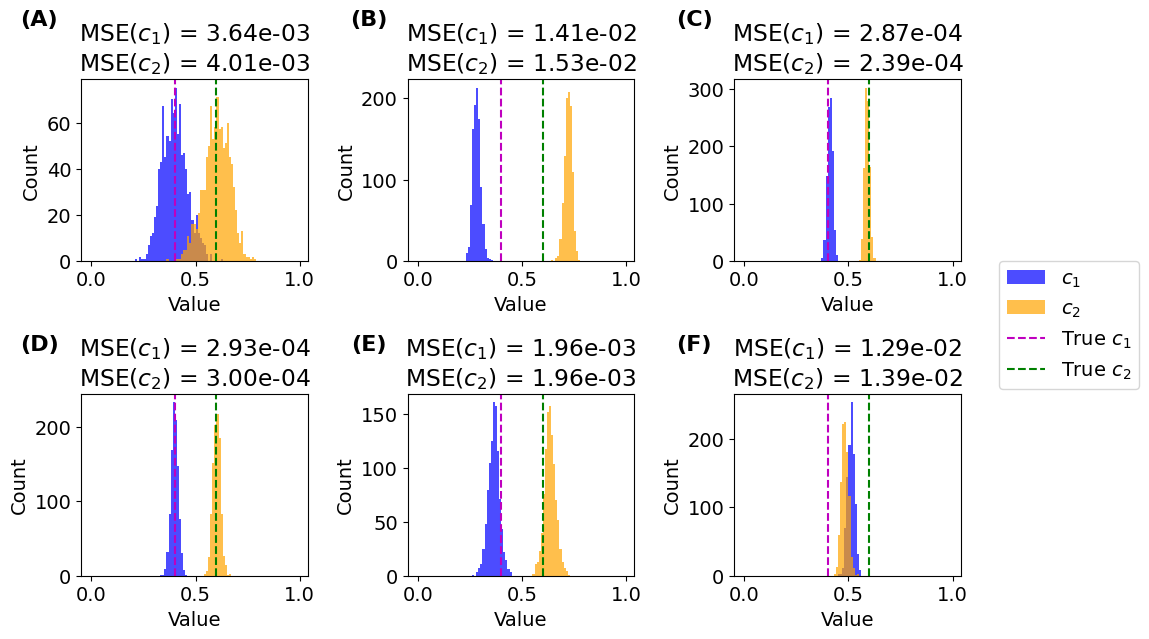

In [29]:
SNR_index_oi = -4
T2rat_index_oi = 5

center_oi_list = np.array([[2,2],[ 2,-3],[len(np1_array)//2,len(np2_array)//2],[ -3,2],[ -3, -3]])
hist_titles = ["top left 10%", "top right 10%", "center", "bottom left 10%", "bottom right 10%"]

mat1 = np.where(SNR_array[SNR_index_oi] == SR_SNR)[0]
mat2 = np.where(T2rat_array[T2rat_index_oi] == SR_T2Rat)[0]
SR_index_match = np.intersect1d(mat1,mat2)[0]

T2rat_true_params = [T11, T12, c1, c2, T21, T2rat_array[T2rat_index_oi]*T21]

fig, ax = plt.subplots(2, 3, figsize=(10, 6.5), tight_layout=True)
# fig.suptitle(f"MWF Estimates at Specific Null Point Guess\nNull Point 1 = {TI1star: 0.0f} :: Null Point 2 = {TI2star : 0.0f}\n{var_reps} Iterations :: SNR = {SNR_array[SNR_index_oi] :0.2f}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T21*T2rat_array[T2rat_index_oi]:.0f}]")


for iter in range(len(center_oi_list)):
    center1_ioi = center_oi_list[iter,0]
    center2_ioi = center_oi_list[iter,1]
    plt.rc('font', size = 14)

    x_ax = (iter+1)%3
    y_ax = (iter+1)//3
    
    MSEMat, varMat, sqBMat = calc_MSE(pEst_AIC[center1_ioi, center2_ioi, T2rat_index_oi, SNR_index_oi, :,:], T2rat_true_params)

    bin_array = np.arange(0, 1, 0.01)
    ax[y_ax,x_ax].hist(x=pEst_AIC[center1_ioi, center2_ioi, T2rat_index_oi, SNR_index_oi, :,-4], bins=bin_array, color='b', alpha = 0.7)
    ax[y_ax,x_ax].hist(x=pEst_AIC[center1_ioi, center2_ioi, T2rat_index_oi, SNR_index_oi, :,-3], bins=bin_array, color='orange', alpha = 0.7)
    ax[y_ax,x_ax].axvline(x = true_params[2], color='m', ls = '--')
    ax[y_ax,x_ax].axvline(x = true_params[3], color='g', ls = '--')
    ax[y_ax,x_ax].set_xlabel('Value')
    ax[y_ax,x_ax].set_ylabel('Count')
    ax[y_ax,x_ax].set_title(f"MSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")#{hist_titles[iter]}")#\n

    ymin, ymax = ax[y_ax,x_ax].get_ylim()
    xmin, xmax = ax[y_ax,x_ax].get_xlim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    # ax[y_ax,x_ax].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
    # ax[y_ax,x_ax].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

MSEMat, varMat, sqBMat = calc_MSE(SR_pEst_cf[SR_index_match,:,:], T2rat_true_params)

ax[0,0].hist(x=SR_pEst_cf[SR_index_match,:,-4], bins=bin_array, color='b', label = r'$c_{1}$', alpha = 0.7)
ax[0,0].hist(x=SR_pEst_cf[SR_index_match,:,-3], bins=bin_array, color='orange', label = r'$c_{2}$', alpha = 0.7)
ax[0,0].axvline(x = true_params[2], label = r'True $c_{1}$', color='m', ls = '--')
ax[0,0].axvline(x = true_params[3], label = r'True $c_{2}$', color='g', ls = '--')
ax[0,0].set_xlabel('Value')
ax[0,0].set_ylabel('Count')
ax[0,0].set_title(f"MSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")

xmin, xmax = ax[0,0].get_xlim()
ymin, ymax = ax[0,0].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
# ax[0,0].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
# ax[0,0].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

plt.rc('font', size = 16)
fig.text(0.05,0.97, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.97, '(B)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.97, '(C)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.05,0.47, '(D)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.47, '(E)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.47, '(F)', ha="center", va="center", color="black", weight = "bold")
plt.rc('font', size = 14)

fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

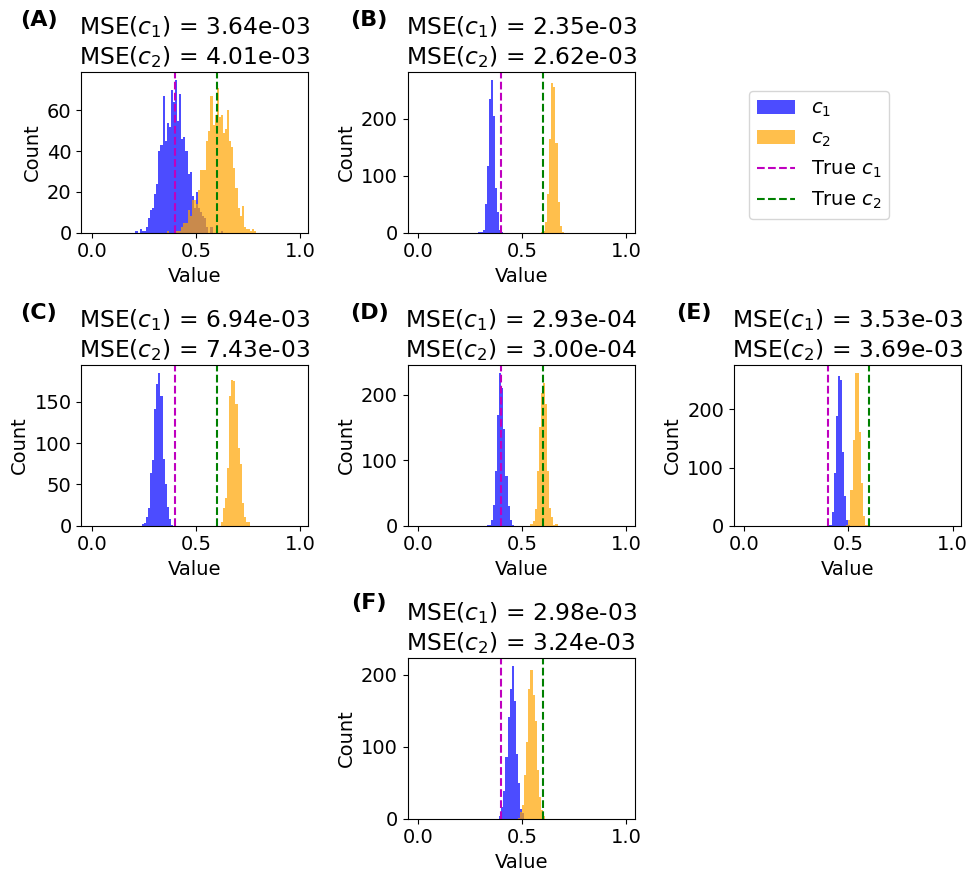

In [30]:
SNR_index_oi = -4
T2rat_index_oi = 5

center_x = len(np1_array)//2
center_y = len(np2_array)//2

center_oi_list = np.array([[2, center_y],[center_x, 2],[center_x, center_y],[center_x, -3],[-3, center_y]])
hist_titles = ["A", 'B', 'C', 'D', 'E']

mat1 = np.where(SNR_array[SNR_index_oi] == SR_SNR)[0]
mat2 = np.where(T2rat_array[T2rat_index_oi] == SR_T2Rat)[0]
SR_index_match = np.intersect1d(mat1,mat2)[0]

T2rat_true_params = [T11, T12, c1, c2, T21, T2rat_array[T2rat_index_oi]*T21]

fig, ax = plt.subplots(3, 3, figsize=(10, 9), tight_layout=True)
# fig.suptitle(f"MWF Estimates at Specific Null Point Guess\nNull Point 1 = {TI1star: 0.0f} :: Null Point 2 = {TI2star : 0.0f}\n{var_reps} Iterations :: SNR = {SNR_array[SNR_index_oi] :0.2f}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T21*T2rat_array[T2rat_index_oi]:.0f}]")

x_ax_list = [1,0,1,2,1]
y_ax_list = [0,1,1,1,2]

for iter in range(len(center_oi_list)):
    center1_ioi = center_oi_list[iter,0]
    center2_ioi = center_oi_list[iter,1]
    plt.rc('font', size = 14)

    x_ax = x_ax_list[iter]
    y_ax = y_ax_list[iter]
    
    MSEMat, varMat, sqBMat = calc_MSE(pEst_AIC[center1_ioi, center2_ioi, T2rat_index_oi, SNR_index_oi, :,:], T2rat_true_params)

    bin_array = np.arange(0, 1, 0.01)
    ax[y_ax,x_ax].hist(x=pEst_AIC[center1_ioi, center2_ioi, T2rat_index_oi, SNR_index_oi, :,-4], bins=bin_array, color='b', alpha = 0.7)
    ax[y_ax,x_ax].hist(x=pEst_AIC[center1_ioi, center2_ioi, T2rat_index_oi, SNR_index_oi, :,-3], bins=bin_array, color='orange', alpha = 0.7)
    ax[y_ax,x_ax].axvline(x = true_params[2], color='m', ls = '--')
    ax[y_ax,x_ax].axvline(x = true_params[3], color='g', ls = '--')
    ax[y_ax,x_ax].set_xlabel('Value')
    ax[y_ax,x_ax].set_ylabel('Count')
    ax[y_ax,x_ax].set_title(f"MSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")

    ymin, ymax = ax[y_ax,x_ax].get_ylim()
    xmin, xmax = ax[y_ax,x_ax].get_xlim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    # ax[y_ax,x_ax].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
    # ax[y_ax,x_ax].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

MSEMat, varMat, sqBMat = calc_MSE(SR_pEst_cf[SR_index_match,:,:], T2rat_true_params)

ax[0,0].hist(x=SR_pEst_cf[SR_index_match,:,-4], bins=bin_array, color='b', label = r'$c_{1}$', alpha = 0.7)
ax[0,0].hist(x=SR_pEst_cf[SR_index_match,:,-3], bins=bin_array, color='orange', label = r'$c_{2}$', alpha = 0.7)
ax[0,0].axvline(x = true_params[2], label = r'True $c_{1}$', color='m', ls = '--')
ax[0,0].axvline(x = true_params[3], label = r'True $c_{2}$', color='g', ls = '--')
ax[0,0].set_xlabel('Value')
ax[0,0].set_ylabel('Count')
ax[0,0].set_title(f"MSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")

xmin, xmax = ax[0,0].get_xlim()
ymin, ymax = ax[0,0].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
# ax[0,0].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
# ax[0,0].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

ax[0,-1].set_axis_off()
ax[-1,0].set_axis_off()
ax[-1,-1].set_axis_off()

plt.rc('font', size = 16)
fig.text(0.05,0.97, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.97, '(B)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.05,0.645, '(C)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.645, '(D)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.645, '(E)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.322, '(F)', ha="center", va="center", color="black", weight = "bold")
plt.rc('font', size = 14)

fig.legend(loc='center left', bbox_to_anchor=(0.75, 0.82))

2.0000000000000004
0.003640937730821712
(13, 13, 11, 8, 3)
2
10
Area in the 10% region =  0.0124


Text(0.3, -0.055, 'Conventional\nPreferred')

/home/hamptong2/Stabilization/.venv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/hamptong2/Stabilization/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


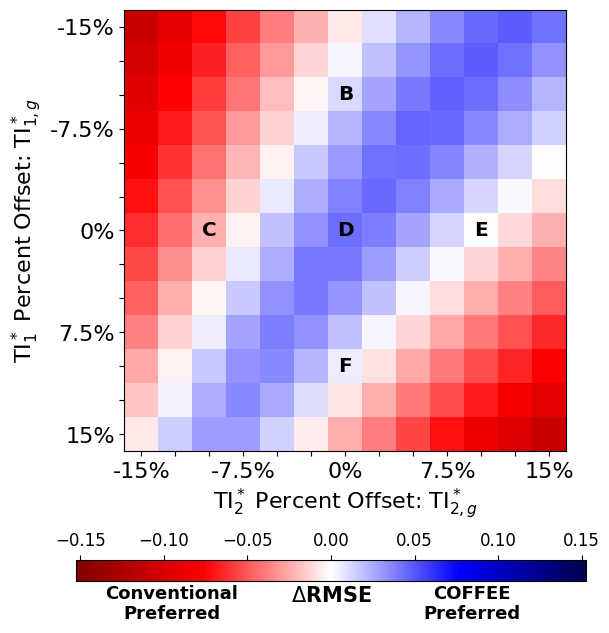

In [31]:
SNR_index_oi = -4
T2rat_index_oi = 5

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize = (6, 7), tight_layout=True)
# fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} RMSE Difference at SNR = {SNR_array[SNR_index_oi] :0.2f}\n Logspaced Conventional - Two Null Point Reassignments\n{ParamTitle_6p}")

mat1 = np.where(SNR_array[SNR_index_oi] == SR_SNR)[0]
mat2 = np.where(T2rat_array[T2rat_index_oi] == SR_T2Rat)[0]
SR_index_match = np.intersect1d(mat1,mat2)[0]

temp_SR_MSE = SR_MSE[SR_index_match,param_oi]

print(T2rat_array[T2rat_index_oi])
print(temp_SR_MSE)
print(MSE.shape)

temp_MSE_imp = temp_SR_MSE**(1/2)-MSE[:, : , T2rat_index_oi, SNR_index_oi, 0]**(1/2)

# temp_max = np.max(np.abs(temp_MSE_imp))

gen_patchwork_panel_final(fig, ax, T2rat_array[T2rat_index_oi], temp_MSE_imp, cb_range = max_val)
tenD = np.where(np.abs(np1_array/TI1star - -0.1) < 0.003)[0][0]
tenU = np.where(np.abs(np1_array/TI1star - 0.1) < 0.003)[0][0]
print(tenD)
print(tenU)
# ax.plot([tenD, tenD, tenU, tenU, tenD],[tenD, tenU, tenU, tenD, tenD], ls = '--', color = 'k', lw = 3, label = '10 percent region')
# ax.legend()
# ax_MSE[1,2].remove()

ex_area = np.mean(temp_MSE_imp[tenD:tenU, tenD:tenU])#trapz_3d(np1_array[tenD:tenU], np2_array[tenD:tenU], temp_MSE_imp[tenD:tenU, tenD:tenU])
print(f'Area in the 10% region = {ex_area: .4f}')
# ax.set_title(f'Area in the 10% region = {ex_area: .4f}')
ax.text(center_y, 2, "B", fontsize = 'large', fontweight = 'bold', ha = 'center', va = 'center')
ax.text(2, center_x, "C", fontsize = 'large', fontweight = 'bold', ha = 'center', va = 'center')
ax.text(center_y, center_x, "D", fontsize = 'large', fontweight = 'bold', ha = 'center', va = 'center')
ax.text(len(np1_array)-3, center_x, "E", fontsize = 'large', fontweight = 'bold', ha = 'center', va = 'center')
ax.text(center_y, len(np1_array)-3, "F", fontsize = 'large', fontweight = 'bold', ha = 'center', va = 'center')
# fig.legend(loc = 'center left', bbox_to_anchor = (0.9,0.5))

cbar_ax = fig.add_axes([0.14, 0, 0.85, 0.03])
cbar = fig.colorbar(imc_hold, cax=cbar_ax, orientation = 'horizontal', location = 'top', extend = extend_opt)#, format = '%.2e')
# cbar.formatter.set_powerlimits((0,0))
cbar.set_label(label=r'$\Delta$RMSE',size=15, weight='bold')
cbar.ax.xaxis.set_label_position('bottom')
fig.text(0.8, -0.055, "COFFEE\nPreferred", ha = 'center', size=13, weight = 'bold')
fig.text(0.3, -0.055, "Conventional\nPreferred", ha = 'center', size=13, weight = 'bold')